In [1]:
import re

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.lines import Line2D
import matplotlib.patheffects as path_effects
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Roboto Condensed']

from scipy.stats import mannwhitneyu

from tqdm import tqdm

## Data loading

We start by loading the manuscript attestation data from the prior work in which we were involved. This data contains information on individual witnesses from the wonderful [Handschriftencensus](https://www.handschriftencensus.de/) dataset, enriched with some additional data, such as an estimated date range for the manuscript itself and the work contained in it. We convert this data range to a single integer in both columns.

In [2]:
sc = pd.read_excel('../data/science-german.xlsx', engine='openpyxl')
sc['date work'] = sc['date work'].ffill()

def parse_date(date_str):
    if pd.isna(date_str):
        return None
    dates = re.findall(r'\d{4}', str(date_str))
    return (int(dates[0]) + int(dates[-1])) // 2 if dates else None

sc['date work'] = sc['date work'].apply(parse_date)
sc['date witness'] = sc['date witness'].apply(parse_date)
sc.rename({'date work': 'date_work', 'date witness': 'date_witness'}, axis=1, inplace=True)
sc

,author,title,date_work,signature,repository,date_witness,fragmentary,subgenre
0,anonymous,Abor und das Meerweib,1325.0,"Kopenhagen, Königl. Bibl., NKS Cod. 4843,4°","Kopenhagen, Königl. Bibl.",1325.0,True,arthurian
1,Albrecht von Kemenaten,Goldemar,1225.0,"Nürnberg, Germanisches Nationalmuseum, Bibliot...","Nürnberg, Germanisches Nationalmuseum",1356.0,False,other
2,anonymous,Alpharts Tod,1275.0,"Berlin, Staatsbibl., mgf 856; Darmstadt, Unive...","Berlin, Staatsbibl. ; Darmstadt, Universitäts-...",1464.0,False,other
3,anonymous,Bairisch-österreichisches Buch von Troja (früh...,1350.0,"Berlin, Staatsbibl., mgq 1145","Berlin, Staatsbibl.",1450.0,False,other
4,anonymous,Bairisch-österreichisches Buch von Troja (früh...,1350.0,"Klagenfurt, Landesarchiv, Arnoldstein, Kloster...","Klagenfurt, Landesarchiv",1476.0,False,other
...,...,...,...,...,...,...,...,...
1072,Wolfram von Eschenbach,Willehalm,1215.0,"Leipzig, Universitätsbibl., Ms. 1614, Bl. 12–...","Leipzig, Universitätsbibl. ; Leipzig, Univers...",1300.0,True,chanson
1073,Wolfram von Eschenbach,Willehalm,1215.0,"Wien, Österr. Nationalbibl., Cod.Ser.nova 286","Wien, Österr. Nationalbibl.",1325.0,True,chanson
1074,Wolfram von Eschenbach,Willehalm,1215.0,"Berlin, Staatsbibl., Hdschr. 394, Pergament, e...","Berlin, Staatsbibl. ; Berlin, Staatsbibl. ; Ke...",1325.0,True,chanson
1075,Wolfram von Eschenbach,Willehalm,1215.0,"Bern, Burgerbibl., Cod. 756,40","Bern, Burgerbibl.",1300.0,True,chanson


We restructure this manuscript-level data to get a work-level summary, including the number of manuscripts and the average date of witnesses for each work. We also calculate the number of manuscripts that predate 1330 for each work (cf. `restricted_counts`), which will be used to analyze the relationship between early manuscript transmission and witness delay.

In [3]:
per_work = sc.groupby(['author', 'title'], as_index=False).agg({
    'date_work': 'first',
    'signature': 'count',
    'date_witness': 'mean'
})

restricted_counts = sc[sc['date_witness'] < 1330].groupby(['author', 'title'], as_index=False).agg({
    'signature': 'count'
}).rename(columns={'signature': 'restrict_manuscript_count'})
per_work = per_work.merge(restricted_counts, on=['author', 'title'], how='left')
per_work['restrict_manuscript_count'] = per_work['restrict_manuscript_count'].fillna(0)

per_work = per_work.rename(columns={'signature': 'manuscript_count', 'date_witness': 'avg_date_witness'})
per_work['avg_witness_delay'] = per_work['avg_date_witness'] - per_work['date_work']
per_work = per_work.dropna()
per_work.head(10)

,author,title,date_work,manuscript_count,avg_date_witness,restrict_manuscript_count,avg_witness_delay
0,Albrecht von Kemenaten,Goldemar,1225.0,1,1356.000000,0.0,131.000000
1,Albrecht von Scharfenberg,Der jüngere Titurel,1250.0,60,1355.550000,27.0,105.550000
2,Berthold von Holle,Crane,1251.0,4,1373.750000,1.0,122.750000
3,Berthold von Holle,Darifant,1251.0,1,1350.000000,0.0,99.000000
4,Berthold von Holle,Demantin,1251.0,3,1354.333333,1.0,103.333333
5,Der Pleier,Garel,1265.0,2,1362.500000,1.0,97.500000
6,Der Pleier,Meleranz,1265.0,1,1480.000000,0.0,215.000000
7,Der Pleier,Tandareis und Flordibel,1265.0,7,1434.285714,0.0,169.285714
8,Dietrich von Hopfgarten,Wigelis,1338.0,1,1455.000000,0.0,117.000000
9,Eilhart von Oberge,Tristrant,1175.0,8,1332.125000,4.0,157.125000


We also load the shortlist data from the Exkurse, as we are interested in the correlation between an author's appearance in these at the attestation frequencies of their work:

In [4]:
canons = pd.read_excel('../data/german-canons.xlsx', engine='openpyxl')
canons = canons[['Source Author', 'Source Work', 'Referenced Author (standardized)']]
canons.columns = ['src-author', 'src-work', 'trg-author']
canons['canon'] = canons['src-author'] + ': ' + canons['src-work']
canons.sample(10)

,src-author,src-work,trg-author,canon
189,Ottokar,Österreichische Reimchronik,Frauenlob,Ottokar: Österreichische Reimchronik
32,Heinrich von dem Türlin,Der Âventiure Crône,Hug von Salza,Heinrich von dem Türlin: Der Âventiure Crône
164,Reinbot von Durne,Der heilige Georg,Hartmann von Aue,Reinbot von Durne: Der heilige Georg
72,Hugo von Trimberg,Der Renner,Gottfried von Neifen,Hugo von Trimberg: Der Renner
65,Rudolf von Ems,Willehalm von Orlens,Ulrich von Türheim,Rudolf von Ems: Willehalm von Orlens
19,Rubin,Reymar mich ruwet sere,Bruder Wernher,Rubin: Reymar mich ruwet sere
137,Der Pleier,Meleranz,Wolfram von Eschenbach,Der Pleier: Meleranz
18,Rubin,Reymar mich ruwet sere,Neidhart,Rubin: Reymar mich ruwet sere
53,Rudolf von Ems,Willehalm von Orlens,Gottfried von Straßburg,Rudolf von Ems: Willehalm von Orlens
4,Reinmar von Brennenberg,Wâ sint nu alle die von minnen sungen ê?,Ulrich von Singenberg,Reinmar von Brennenberg: Wâ sint nu alle die v...


## Canonity verses attestation

Let us start with a simple binary question: do authors who occur at all in the list of canons, have more manuscripts overall than those who do not? First, we need to collapse the attestation counts across all works of an author (while ignoring anonymous works):

In [5]:
# total manuscript counts per author (but excluding anonymous!)
author_counts = sc[sc['author'] != 'anonymous']['author'].value_counts().reset_index()
author_counts.columns = ['author', 'manuscript_count']

restricted_author_counts = sc[(sc['author'] != 'anonymous') & (sc['date_witness'] < 1330)]['author'].value_counts().reset_index()
restricted_author_counts.columns = ['author', 'restrict_manuscript_count']

author_counts = author_counts.merge(restricted_author_counts, on='author', how='left')

author_counts['restrict_manuscript_count'] = author_counts['restrict_manuscript_count'].fillna(0)

author_counts.head(10)

,author,manuscript_count,restrict_manuscript_count
0,Wolfram von Eschenbach,169,124.0
1,Rudolf von Ems,103,47.0
2,Albrecht von Scharfenberg,60,27.0
3,Hartmann von Aue,57,33.0
4,Ulrich von Türheim,48,30.0
5,Stricker,46,21.0
6,Wirnt von Grafenberg,38,21.0
7,Gottfried von Straßburg,30,20.0
8,Ulrich von dem Türlin,27,14.0
9,Konrad von Würzburg,21,7.0


Next, we use the canon data to identify in how many distinct shortlists individual authors are present:

In [6]:
canon_counts = canons.groupby('trg-author')['canon'].nunique().reset_index()
canon_counts.columns = ['author', 'distinct_canons']
canon_counts = canon_counts.sort_values(by='distinct_canons', ascending=False)
canon_counts.head(10)

,author,distinct_canons
82,Wolfram von Eschenbach,20
19,Hartmann von Aue,13
79,Walther von der Vogelweide,10
25,Heinrich von Veldeke,9
18,Gottfried von Straßburg,7
47,Neidhart,7
54,Reinmar den Alten,5
39,Konrad von Würzburg,4
43,Marner,4
24,Heinrich von Rugge,4


We can now merge these two tables:

In [7]:
author_counts = author_counts.merge(canon_counts, on='author', how='left')
author_counts['distinct_canons'] = author_counts['distinct_canons'].fillna(0).astype(int)
author_counts.sample(10)

,author,manuscript_count,restrict_manuscript_count,distinct_canons
12,Ulrich von Etzenbach,18,7.0,0
3,Hartmann von Aue,57,33.0,13
6,Wirnt von Grafenberg,38,21.0,2
19,Eilhart von Oberge,8,4.0,0
22,Ulrich Fuetrer,6,0.0,0
16,Elisabeth von Nassau-Saarbrücken,10,0.0,0
35,Dietrich von Hopfgarten,1,0.0,0
5,Stricker,46,21.0,2
10,Seifrit,20,0.0,0
30,Pfaffe Lambrecht,3,2.0,0


We can now verify our basicn binary hypothesis that mere canon presence should be associated with a higher manuscript count:

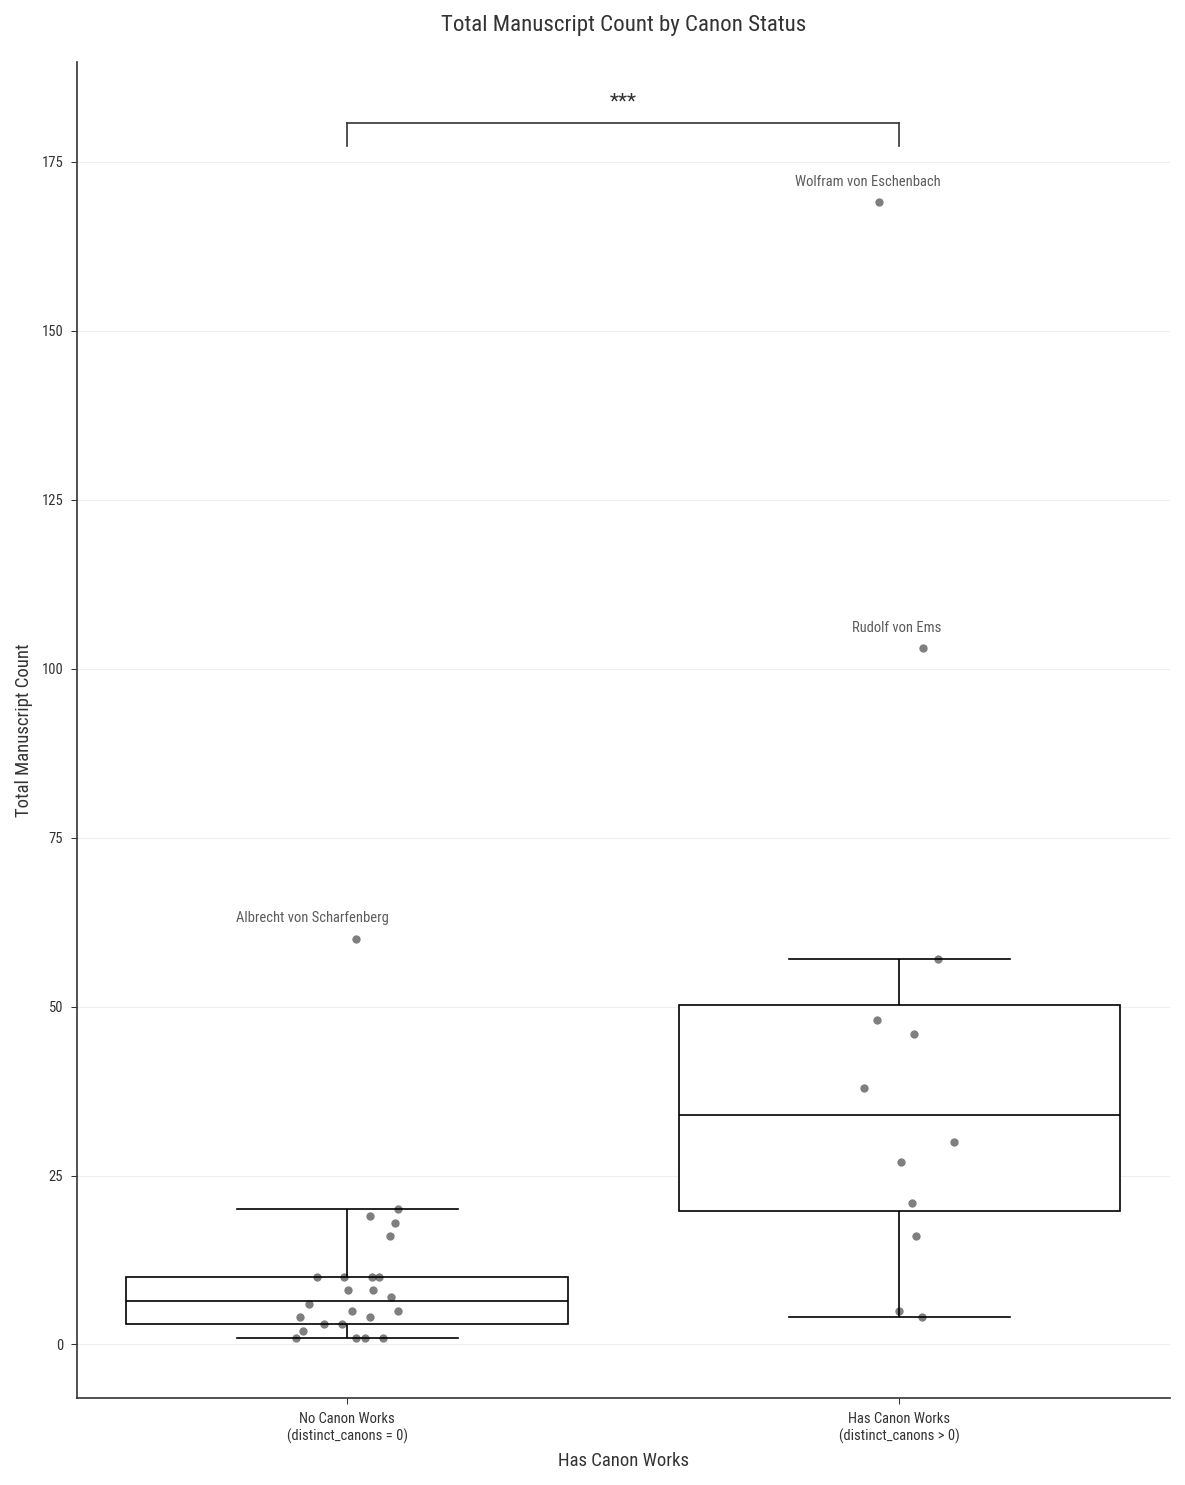

Mann-Whitney U statistic: 246.5
One-sided p-value: 3.0207e-04


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import numpy as np

author_counts['has_canon'] = author_counts['distinct_canons'] > 0

fig, ax = plt.subplots(figsize=(8, 10), dpi=150)
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

grid_color = '#e0e0e0'
text_color = '#333333'
box_color = '#000000'

box_plot = sns.boxplot(data=author_counts, x='has_canon', y='manuscript_count', 
            color='white', 
            linewidth=2,
            fliersize=0,
            ax=ax)

for patch in ax.patches:
    patch.set_edgecolor(box_color)
    patch.set_facecolor('white')
    patch.set_linewidth(0.8)

for i, line in enumerate(ax.lines):
    line.set_color(box_color)
    line.set_linewidth(0.8)

strip = sns.stripplot(data=author_counts, x='has_canon', y='manuscript_count', 
              color=box_color, alpha=0.5, size=4, ax=ax)

box_data = [author_counts[author_counts['has_canon'] == False]['manuscript_count'].values,
            author_counts[author_counts['has_canon'] == True]['manuscript_count'].values]

whisker_tops = []
for i, data in enumerate(box_data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    upper_whisker = q3 + 1.5 * iqr
    whisker_tops.append(upper_whisker)

strip_positions = {}
for collection in strip.collections:
    offsets = collection.get_offsets()
    for x, y in offsets:
        x_rounded = int(round(x))
        if x_rounded not in strip_positions:
            strip_positions[x_rounded] = []
        strip_positions[x_rounded].append(y)

for i, has_canon_val in enumerate([False, True]):
    subset = author_counts[author_counts['has_canon'] == has_canon_val]
    outliers = subset[subset['manuscript_count'] > whisker_tops[i]]
    
    for idx, row in outliers.iterrows():
        y_val = row['manuscript_count']
        x_positions = strip_positions.get(i, [])
        
        matching_x = None
        for strip_y in x_positions:
            if abs(strip_y - y_val) < 0.5:
                matching_x = i
                break
        
        if matching_x is not None:
            ax.annotate(row['author'], 
                       xy=(matching_x, y_val),
                       xytext=(20, 10),
                       textcoords='offset points',
                       fontsize=7,
                       color=text_color,
                       ha='right',
                       va='center',
                       alpha=0.8)

group_no_canon = author_counts[author_counts['has_canon'] == False]['manuscript_count']
group_has_canon = author_counts[author_counts['has_canon'] == True]['manuscript_count']

statistic, p_value = mannwhitneyu(group_has_canon, group_no_canon, alternative='greater')

if p_value < 0.001:
    sig_text = '***'
elif p_value < 0.01:
    sig_text = '**'
elif p_value < 0.05:
    sig_text = '*'
else:
    sig_text = 'ns'

y_max = author_counts['manuscript_count'].max()
y_range = author_counts['manuscript_count'].max() - author_counts['manuscript_count'].min()
bracket_height = y_max + y_range * 0.05
line_height = bracket_height + y_range * 0.02

ax.plot([0, 0], [bracket_height, line_height], color=text_color, linewidth=0.8)
ax.plot([1, 1], [bracket_height, line_height], color=text_color, linewidth=0.8)
ax.plot([0, 1], [line_height, line_height], color=text_color, linewidth=0.8)

ax.text(0.5, line_height + y_range * 0.01, sig_text, 
        ha='center', va='bottom', fontsize=10, color=text_color)

ax.set_title('Total Manuscript Count by Canon Status', 
             fontsize=11, color=text_color, pad=15, fontweight='normal')
ax.set_xlabel('Has Canon Works', fontsize=9, color=text_color)
ax.set_ylabel('Total Manuscript Count', fontsize=9, color=text_color)

ax.set_xticks([0, 1])
ax.set_xticklabels(['No Canon Works\n(distinct_canons = 0)', 
                    'Has Canon Works\n(distinct_canons > 0)'],
                   fontsize=7, color=text_color)

ax.tick_params(axis='both', labelsize=7, colors=text_color, length=3, width=0.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color(text_color)
ax.spines['bottom'].set_color(text_color)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)

ax.grid(axis='y', color=grid_color, alpha=0.5, linewidth=0.5, linestyle='-')
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('../figures/manuscript_count_by_canon_status.png', dpi=300, 
            bbox_inches='tight', facecolor='white', edgecolor='none')
plt.show()

print(f"Mann-Whitney U statistic: {statistic}")
print(f"One-sided p-value: {p_value:.4e}")

The plot above efficiently communicates visually that are hypothesis is highly compatible with the evidence. A directional statistical test (a conventional non-parametric Mann-Whitney *U*) confirms that the difference in manuscript counts between authors with canon works and those without is highly meaningful. This suggests that authors with canon works tend to have higher manuscript counts, supporting the idea that being included in canons is associated with greater manuscript transmission. Above, we annotate the dots of the underlying strip plot with author's labels, for those dots that are outliers.

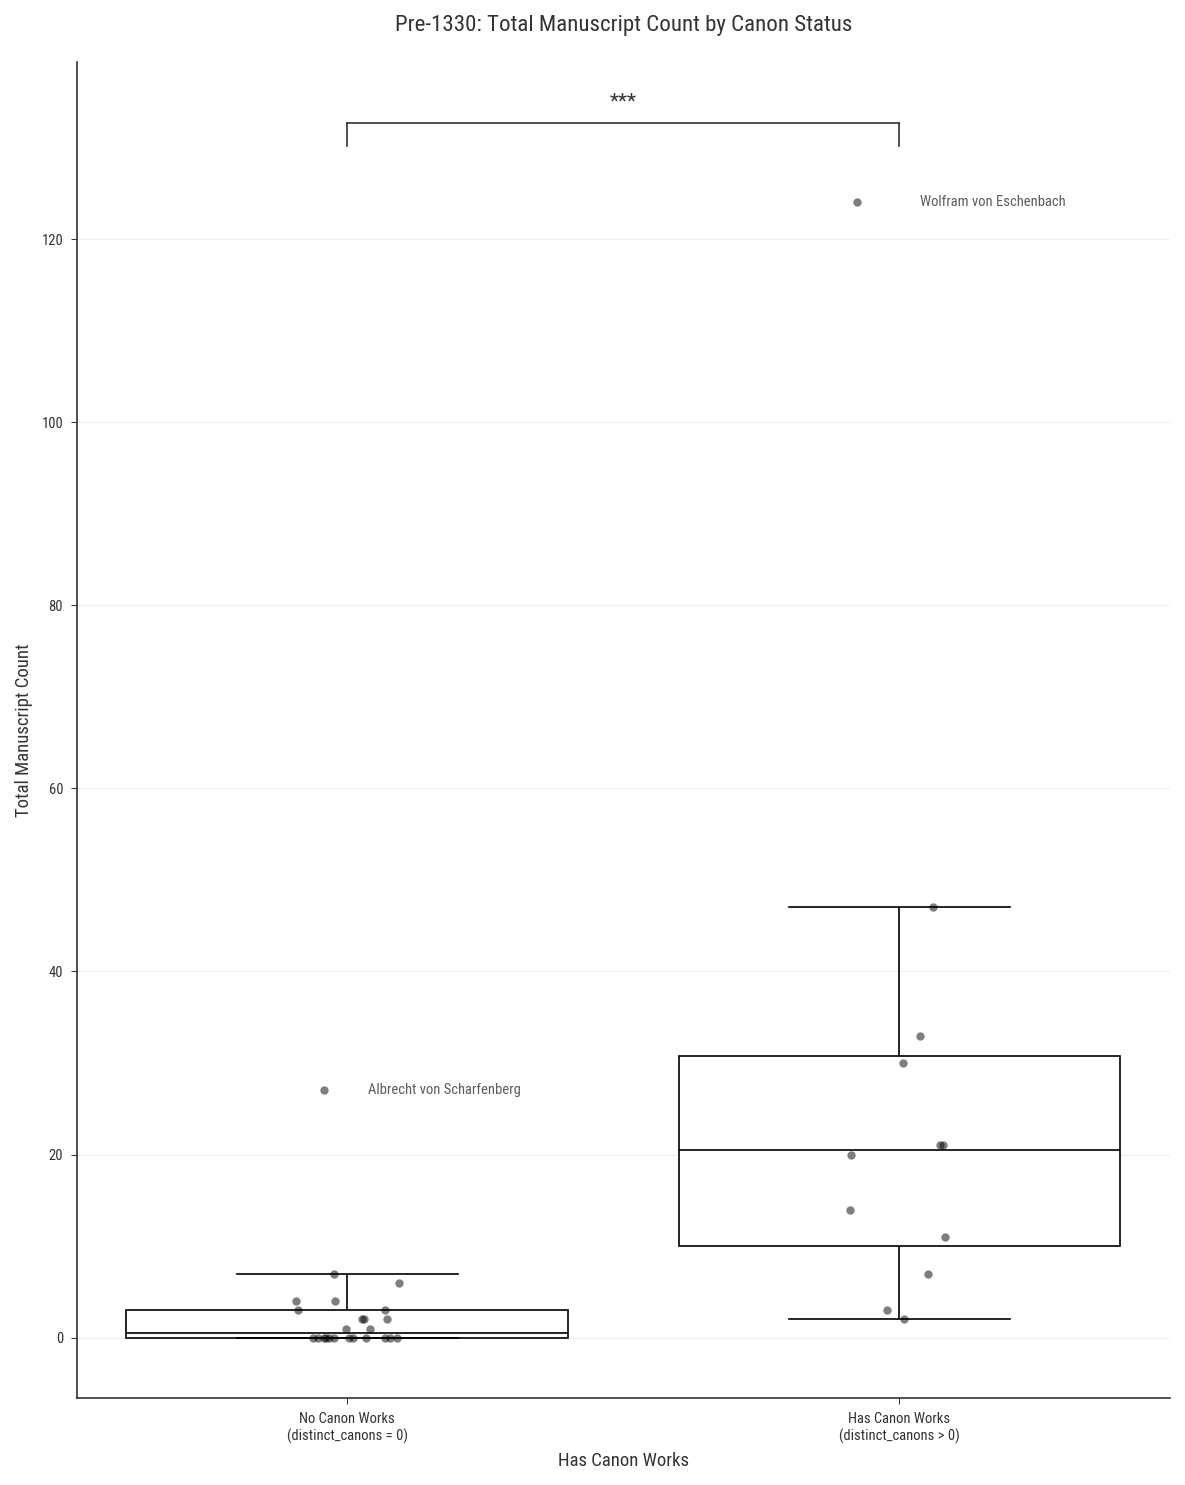

Mann-Whitney U statistic: 267.0
One-sided p-value: 1.3723e-05


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import numpy as np

author_counts['has_canon'] = author_counts['distinct_canons'] > 0

fig, ax = plt.subplots(figsize=(8, 10), dpi=150)
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

grid_color = '#e0e0e0'
text_color = '#333333'
box_color = '#000000'

box_plot = sns.boxplot(data=author_counts, x='has_canon', y='restrict_manuscript_count', 
            color='white', 
            linewidth=2,
            fliersize=0,
            ax=ax)

for patch in ax.patches:
    patch.set_edgecolor(box_color)
    patch.set_facecolor('white')
    patch.set_linewidth(0.8)

for i, line in enumerate(ax.lines):
    line.set_color(box_color)
    line.set_linewidth(0.8)

strip = sns.stripplot(data=author_counts, x='has_canon', y='restrict_manuscript_count', 
              color=box_color, alpha=0.5, size=4, ax=ax)

box_data = [author_counts[author_counts['has_canon'] == False]['restrict_manuscript_count'].dropna().values,
            author_counts[author_counts['has_canon'] == True]['restrict_manuscript_count'].dropna().values]

whisker_tops = []
for i, data in enumerate(box_data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    upper_whisker = q3 + 1.5 * iqr
    whisker_tops.append(upper_whisker)

strip_positions = {}
for collection in strip.collections:
    offsets = collection.get_offsets()
    for x, y in offsets:
        x_rounded = int(round(x))
        if x_rounded not in strip_positions:
            strip_positions[x_rounded] = []
        strip_positions[x_rounded].append(y)

for i, has_canon_val in enumerate([False, True]):
    subset = author_counts[author_counts['has_canon'] == has_canon_val].dropna(subset=['restrict_manuscript_count'])
    outliers = subset[subset['restrict_manuscript_count'] > whisker_tops[i]]
    
    for idx, row in outliers.iterrows():
        y_val = row['restrict_manuscript_count']
        x_positions = strip_positions.get(i, [])
        
        matching_x = None
        for strip_y in x_positions:
            if abs(strip_y - y_val) < 0.5:
                matching_x = i
                break
        
        if matching_x is not None:
            ax.annotate(row['author'], 
                       xy=(matching_x, y_val),
                       xytext=(10, 0),
                       textcoords='offset points',
                       fontsize=7,
                       color=text_color,
                       ha='left',
                       va='center',
                       alpha=0.8)

group_no_canon = author_counts[author_counts['has_canon'] == False]['restrict_manuscript_count'].dropna()
group_has_canon = author_counts[author_counts['has_canon'] == True]['restrict_manuscript_count'].dropna()

statistic, p_value = mannwhitneyu(group_has_canon, group_no_canon, alternative='greater')

if p_value < 0.001:
    sig_text = '***'
elif p_value < 0.01:
    sig_text = '**'
elif p_value < 0.05:
    sig_text = '*'
else:
    sig_text = 'ns'

y_max = author_counts['restrict_manuscript_count'].max()
y_range = author_counts['restrict_manuscript_count'].max() - author_counts['restrict_manuscript_count'].min()
bracket_height = y_max + y_range * 0.05
line_height = bracket_height + y_range * 0.02

ax.plot([0, 0], [bracket_height, line_height], color=text_color, linewidth=0.8)
ax.plot([1, 1], [bracket_height, line_height], color=text_color, linewidth=0.8)
ax.plot([0, 1], [line_height, line_height], color=text_color, linewidth=0.8)

ax.text(0.5, line_height + y_range * 0.01, sig_text, 
        ha='center', va='bottom', fontsize=10, color=text_color)

ax.set_title('Pre-1330: Total Manuscript Count by Canon Status', 
             fontsize=11, color=text_color, pad=15, fontweight='normal')
ax.set_xlabel('Has Canon Works', fontsize=9, color=text_color)
ax.set_ylabel('Total Manuscript Count', fontsize=9, color=text_color)

ax.set_xticks([0, 1])
ax.set_xticklabels(['No Canon Works\n(distinct_canons = 0)', 
                    'Has Canon Works\n(distinct_canons > 0)'],
                   fontsize=7, color=text_color)

ax.tick_params(axis='both', labelsize=7, colors=text_color, length=3, width=0.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color(text_color)
ax.spines['bottom'].set_color(text_color)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)

ax.grid(axis='y', color=grid_color, alpha=0.5, linewidth=0.5, linestyle='-')
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('../figures/restrict_manuscript_count_by_canon_status.png', dpi=300, 
            bbox_inches='tight', facecolor='white', edgecolor='none')
plt.show()

print(f"Mann-Whitney U statistic: {statistic}")
print(f"One-sided p-value: {p_value:.4e}")

Finally we produce a list of authors who have the highest attestation frequency, while not being mentioned in any shortlists:

In [10]:
no_canon_authors = author_counts[author_counts['distinct_canons'] == 0]
no_canon_sorted = no_canon_authors.sort_values('manuscript_count', ascending=False)
no_canon_sorted.head(10)

,author,manuscript_count,restrict_manuscript_count,distinct_canons,has_canon
2,Albrecht von Scharfenberg,60,27.0,0,False
10,Seifrit,20,0.0,0,False
11,Johann von Würzburg,19,1.0,0,False
12,Ulrich von Etzenbach,18,7.0,0,False
13,Meister Wichwolt [früher: Babiloth],16,0.0,0,False
15,Hans Mair von Nördlingen,10,0.0,0,False
16,Elisabeth von Nassau-Saarbrücken,10,0.0,0,False
17,Der Pleier,10,1.0,0,False
18,Heinrich von Freiberg,10,4.0,0,False
19,Eilhart von Oberge,8,4.0,0,False


Finally, let us go beyond mere shortlist presence: is there a more general relationship between the precise number of canons in which an author is mentioned and their manuscript count? We this we run a Poission regression, model that is very well suited to model the behaviour of integers.

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, distinct_canons]


/Users/mikekestemont/miniconda3/envs/bayes/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:754: RuntimeWarning: overflow encountered in exp
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/mikekestemont/miniconda3/envs/bayes/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:754: RuntimeWarning: overflow encountered in exp
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/mikekestemont/miniconda3/envs/bayes/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:754: RuntimeWarning: overflow encountered in exp
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/mikekestemont/miniconda3/envs/bayes/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:754: RuntimeWarning: overflow encountered in exp
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
/Users/mikekestemont/miniconda3/envs/bayes/lib/python3.10/site-packages/arviz/rcparams.py:368: FutureWarn

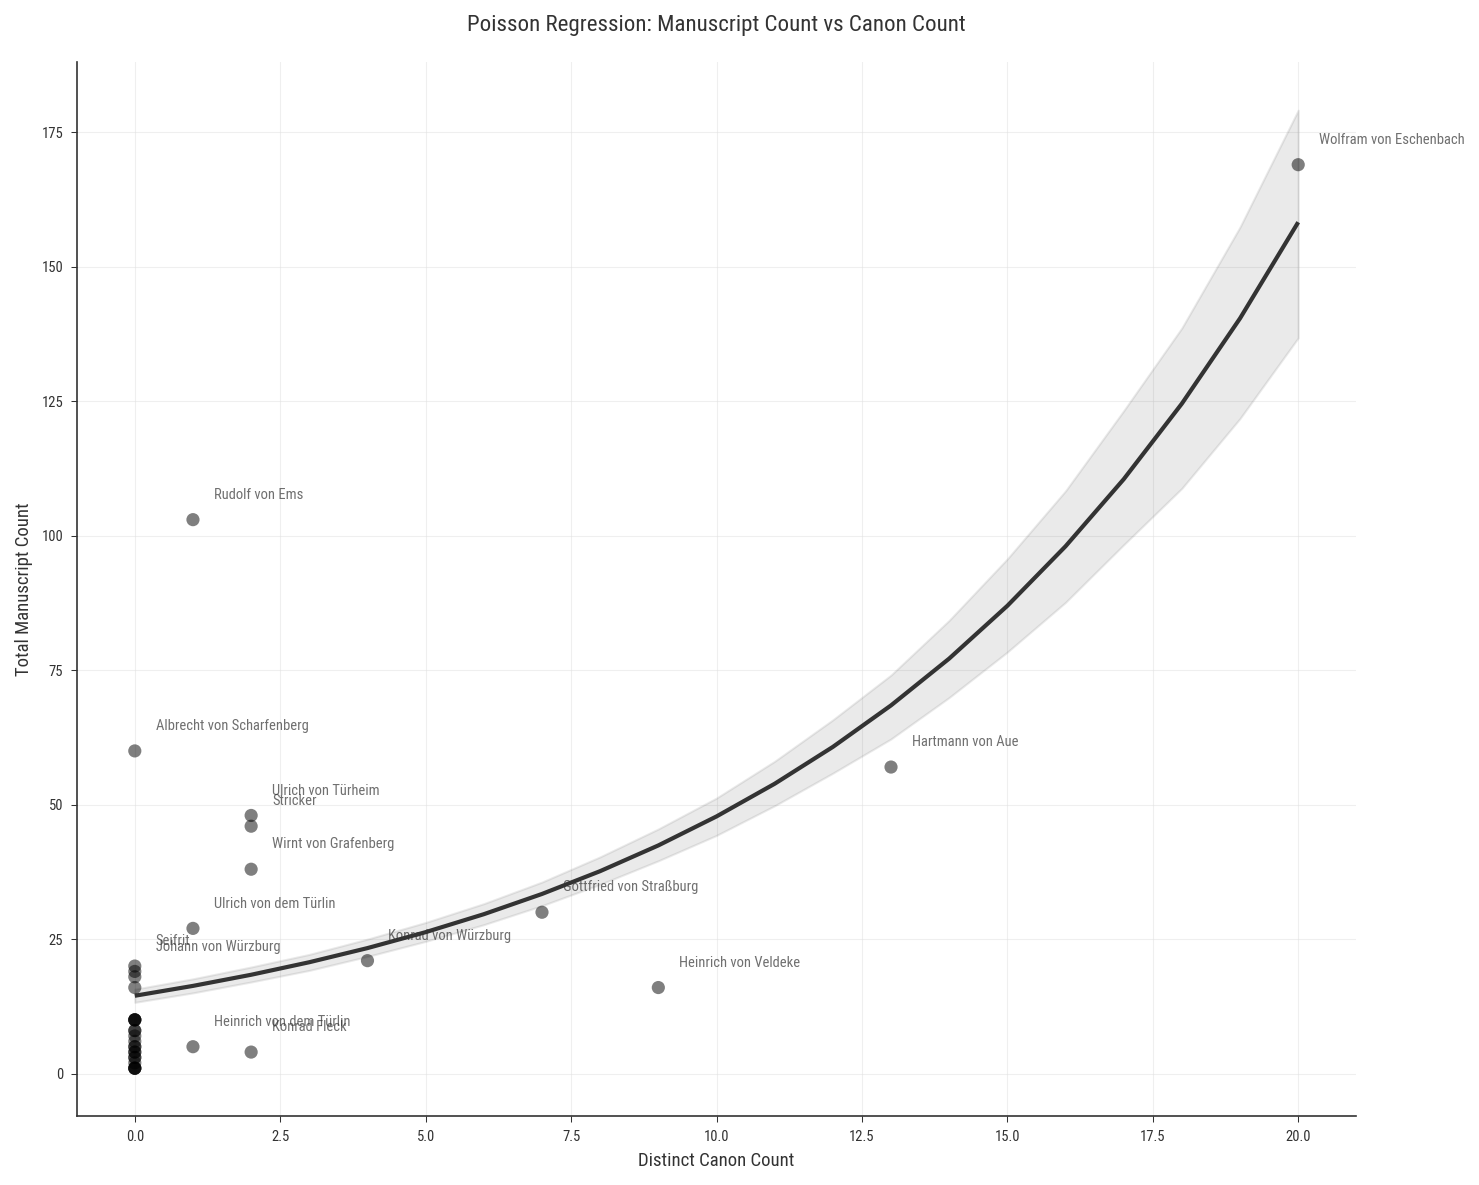

                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
Intercept        2.671  0.045   2.587    2.756      0.001      0.0    4177.0    5187.0    1.0
distinct_canons  0.120  0.004   0.111    0.128      0.000      0.0    4975.0    5367.0    1.0

Poisson Regression Summary:
Intercept (β₀): 2.671
Slope (β₁): 0.120
Rate ratio: 1.127
Effect: 12.7% increase per additional canon work


In [11]:
import os
os.environ['PYTENSOR_FLAGS'] = 'optimizer=fast_compile,cxx='

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import bambi as bmb
import arviz as az

model = bmb.Model('manuscript_count ~ distinct_canons', 
                  author_counts, 
                  family='poisson')

idata = model.fit(draws=2000, tune=1000, chains=4, random_seed=42)

fig, ax = plt.subplots(figsize=(10, 8), dpi=150)
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

grid_color = '#e0e0e0'
text_color = '#333333'
point_color = '#000000'

bmb.interpret.plot_predictions(
    model, 
    idata, 
    conditional='distinct_canons',
    ax=ax
)

for line in ax.get_lines():
    line.set_color(text_color)
    line.set_linewidth(2)

for collection in ax.collections:
    collection.set_facecolor(text_color)
    collection.set_edgecolor(text_color)
    collection.set_alpha(0.1)

ax.scatter(author_counts['distinct_canons'], 
          author_counts['manuscript_count'], 
          alpha=0.5, s=40, color=point_color, 
          edgecolors='none', zorder=3, label='Observed')

author_counts['combined_score'] = author_counts['distinct_canons'] * author_counts['manuscript_count']
top_authors = author_counts.nlargest(15, 'combined_score')

for _, row in top_authors.iterrows():
    ax.annotate(row['author'], 
                (row['distinct_canons'], row['manuscript_count']),
                xytext=(10, 10), textcoords='offset points',
                fontsize=7, color=text_color, alpha=0.7)

ax.set_title('Poisson Regression: Manuscript Count vs Canon Count', 
            fontsize=11, color=text_color, pad=15, fontweight='normal')
ax.set_xlabel('Distinct Canon Count', fontsize=9, color=text_color)
ax.set_ylabel('Total Manuscript Count', fontsize=9, color=text_color)

ax.tick_params(axis='both', labelsize=7, colors=text_color, length=3, width=0.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color(text_color)
ax.spines['bottom'].set_color(text_color)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)

ax.grid(True, color=grid_color, alpha=0.5, linewidth=0.5, linestyle='-')
ax.set_axisbelow(True)

if ax.get_legend():
    ax.get_legend().remove()

plt.tight_layout()
plt.savefig('../figures/bambi_poisson_regression.png', dpi=300, 
            bbox_inches='tight', facecolor='white', edgecolor='none')
plt.show()

print(az.summary(idata, var_names=['Intercept', 'distinct_canons']))

beta0 = idata.posterior['Intercept'].mean().values
beta1 = idata.posterior['distinct_canons'].mean().values
rate_ratio = np.exp(beta1)
percent_increase = (rate_ratio - 1) * 100

print("\nPoisson Regression Summary:")
print("=" * 40)
print(f"Intercept (β₀): {beta0:.3f}")
print(f"Slope (β₁): {beta1:.3f}")
print(f"Rate ratio: {rate_ratio:.3f}")
print(f"Effect: {percent_increase:.1f}% increase per additional canon work")

Note that in the summary table, the HDI for the distinct canons predictor is positive and does not include zero, which indicates a statistically meaningful positive association between distinct canon count and manuscript count. The rate ratio of approximately 1.15 suggests that each additional canon work is associated with a 15% increase in the expected manuscript count, holding all else constant. Note: while the observed attestation counts for the most canonical authors (Gottfried, Hartmann, Wolfram, ...) are reasonable well in line with the model's expectation, there is a surprisingly large group of authors (Rudolf, Albrecht, Ulrich, ...) that have a much richer manuscript record than our canons would lead us to anticipate.